# XGBoost (Customer Churn)
---
In this notebook we will use **XGBoost** to build a collection of boosted trees, and use continuous and categorical data from the **IBM Base Samples** to predict whether or not a customer will **stop using a company's service**. In business lingo, this is called **Customer Churn**. 

We will use `Telco Churn Dataset` for prediction

> **XGBoost** is an exceptionally useful machine learning method when you don't want to sacrifice the ability to correctly classify observations but you still want a model that is fairly easy to understand and interpret.
<br>
> In this notebook we will learn about...
> - **Importing data from a file**
> - **Missing Data**
>  - Identifying Missing Data
>  - Dealing with Missing Data
> - **Formatting the Data for XGBoost**
>  - Splitting data into Dependent and Independent Variables
>  - One Hot Encoding
>  - Converting all columns to Int, Float or Bool
> - **Building a Preliminary XGBoost Model**
> - **Optimizing Parameters with Cross Validation and GridSearch()**
>  - Optimizing the learning rate, tree depth, number of trees, gamma (for pruning) and lambda (for regularization)
> - **Building, Drawing, Interpreting and Evaluating the Optimized XGBoost Model**

### Note:
> For better understanding of this algorithm, one should know the theory behind `XGBoost`, `Cross Validation` and `Confusion Matrices`

## Importing the Required Modules
> The first thing we do is load in a bunch of Python Modules. Python, itself, just gives us a basic programming language. These modules give us extra functionality to import the data, clean it up and format it, and then build, evaluate and draw the **XGBoost** model

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

## Import the Data
> Now we load in a dataset from the `IBM Base Samples`. Specifically, we are going to use the `Telco Churn Dataset`. This dataset will allow us to predict if someone will stop using Telco's services or not using a variety of continuous and categorical datatypes.

In [1]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

od.download('https://www.kaggle.com/blastchar/telco-customer-churn')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: venupodugu
Your Kaggle Key: ··········


100%|██████████| 172k/172k [00:00<00:00, 29.2MB/s]

In [81]:
df = pd.read_csv('./telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [82]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [83]:
df.shape

(7043, 21)

In [8]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


> We will remove `customerID` from the dataset because it is different for every customer and useless for classification.

In [84]:
df.drop(['customerID'], axis=1, inplace=True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


> Also we need to set the `Churn` feature which is our dependent feature to `0`s and `1`s.

In [85]:
df.loc[df['Churn'] == 'Yes', 'Churn'] = 1
df.loc[df['Churn'] == 'No', 'Churn'] = 0
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


## Missing Data

In [70]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

> If we look at the output from `info()`, **TotalCharges** looks like it contains numbers, not text, but the `object` datatype suggests that it contains more than just numbers. If we try the trick of printing out the unique values...

In [86]:
df.TotalCharges.unique()

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

> ...We see that there are too many values to print and what little we see looks like numbers. However, if we try to convert the column to numeric values...

In [72]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

ValueError: ignored

> ...we get an error. This error, however, tells us what the problem is. There are blank spaces " ", in the data. So we need to deal with those.

## Dealing with Missing Data, XGBoost Style
> One thing that is relatively unique about `XGBoost` is that it determines default behavior for missing data. So all we have to do is identify missing values and make sure they are set to `0`

> However, before we do that, let's see how many rows are missing data. If it's a lot, then we might have a problem on our hands that is bigger than what `XGBoost` can deal with on its own. If it's not that many, we can just set them to `0`

In [87]:
len(df.loc[df['TotalCharges'] == ' '])

11

> Since only `11` rows have missing values, let's look at them.

In [88]:
df.loc[df['TotalCharges'] == ' ']

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


> We see that all `11` people with `TotalCharges == " "` have just signed up, because `tenure` is `0`. These people also all have `Churn` equal to `0` because they just signed up. So we have a few choices here, we can set `TotalCharges` to `0` for those `11` people or we can remove them. In this example, we'll try setting `TotalCharges` to `0`

In [89]:
df.loc[(df['TotalCharges'] == ' '), 'TotalCharges'] = 0

> Now let's verify that we modified `TotalCharges` correctly by looking at everyone who had `tenure` set to `0`

In [90]:
df.loc[df['tenure'] == 0]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,0
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,0
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,0
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,0
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,0
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,0
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,0
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,0
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,0
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,0


> We have verified that `df` contains `0`s instead of `" "`s for missing values. 
> ### Note
> `TotalCharges` still has the `object` datatype. That is no good because `XGBoost` only allows `int`, `float` or `boolean` data types. We can fix this by converting it with `to_numeric()`.

In [91]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

> Note that we have dealt with the missing data,we can replace all of the other whitespaces in all of the columns with underscores.
> ### Note
We are only doing this so we can draw a picture of one of the `XGBoost` trees.

In [92]:
df.replace(' ', '_', regex=True, inplace=True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1


## Extracting Dependent and Independent Features
> Now we are ready to start formatting the data for making an `XGBoost` model.

> The first step is to split the data into two parts:
> <br>
> 1. The columns of data that we will use to make classifications
> 2. The column of data that we want to predict

> ### Note
In the code below we are using `copy()` to copy the data `by value`. By default, pandas used copy `by reference`. Using `copy()` ensures that the original data `df` is not modified when we modify `X` or `y` (Independent & Dependent datasets after extracting).

In [97]:
X = df.drop('Churn', axis=1).copy()
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65


In [ ]:
y = df['Churn'].copy()
y.head()

> Now we are ready to continue formatting `X` so that it is suitable for making a model with `XGBoost`.

## One Hot Encoding
> Now we need to take a closer look at the features in `X`. The list below tells us what each variable represents and the type of data (`float` or `categorical`) it should contain:
> - `gender` - Category
>  - Female, Male
> - `SeniorCitizen` - Category
>  - Yes, No
> - `Partner` - Category
>  - Yes, No
> - `Dependents` - Category
>  - Yes, No
> - `tenure` - Float
> - `PhoneService` - Category
>  - Yes, No
> - `MultipleLines` - Category
>  - Yes, No
> - `InternetService` - Category
>  - No, DSL, Figer optic
> - `OnlineSecurity` - Category
>  - Yes, No
> - `OnlineBackup` - Category
>  - Yes, No
> - `DeviceProtection` - Category
>  - Yes, No
> - `TechSupport` - Category
>  - Yes, No
> - `StreamingTV` - Category
>  - Yes, No
> - `StreamingMovies` - Category
>  - Yes, No
> - `Contract` - Category
>  - Month_to_month, One_year, Two_year
> - `PaperlessBilling` - Category
>  - Yes, No
> - `PaymentMethod` - Category
>  - Mailed_Check, Electronic_Check etc...
> - `MonthlyCharges` - Float
> - `TotalCharges` - Float

> Now, just to review, let's look at the data types in `X` t remember how python is seeing the data right now.

In [98]:
X.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
dtype: object

In [99]:
pd.get_dummies(X, columns=['PaymentMethod']).head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,29.85,29.85,0,0,1,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,56.95,1889.50,0,0,0,1
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,53.85,108.15,0,0,0,1
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,42.30,1840.75,1,0,0,0
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,70.70,151.65,0,0,1,0


In [101]:
X_encoded = pd.get_dummies(X, columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
                                         'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                                         'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                                         'Contract', 'PaperlessBilling', 'PaymentMethod'], drop_first=True)
X_encoded.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No_phone_service,MultipleLines_Yes,InternetService_Fiber_optic,InternetService_No,OnlineSecurity_No_internet_service,OnlineSecurity_Yes,OnlineBackup_No_internet_service,OnlineBackup_Yes,DeviceProtection_No_internet_service,DeviceProtection_Yes,TechSupport_No_internet_service,TechSupport_Yes,StreamingTV_No_internet_service,StreamingTV_Yes,StreamingMovies_No_internet_service,StreamingMovies_Yes,Contract_One_year,Contract_Two_year,PaperlessBilling_Yes,PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,1,29.85,29.85,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,34,56.95,1889.50,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,2,53.85,108.15,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,45,42.30,1840.75,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
4,2,70.70,151.65,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [103]:
X_encoded.shape

(7043, 30)

> We have finally finished formatting the data for making an `XGBoost` model, so let's do it!

## Build A Preliminary XGBoost Model
> At long last, the data is correctly formatted for making an `XGBoost` model. Now we simply split the data into `training` and `testing` sets and build the model. However, first, let's observe that this data is imblanced by dividing the number of people who left the company, where `y=1`, by the total number of people in the dataset.

In [104]:
sum(y) / len(y)

0.2653698707936959

> So we see that only `27%` of the people in the dataset left the company. Because of this, when we split the data into training and testing, we will split using stratification in order to maintain the same percentage of people who left the company in both the `training` set and the `testing` set.

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

> Now let's verigy that using `stratify` worked as expected...

In [106]:
sum(y_train) / len(y_train), sum(y_test) / len(y_test)

(0.2654297614539947, 0.26519023282226006)

> `Stratify` worked as expected and both `y_train` and `y_test` have the same percentage of people that left the company. Now let's build the preliminary model.

### Note
> Instead of determining the optimal number of trees with cross validation, we will use `early stopping` to stop building trees when they no longer improve the situation.

In [107]:
clf = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=42)
clf.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, 
        eval_metric='aucpr', eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.596821
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.596821
[2]	validation_0-aucpr:0.616819
[3]	validation_0-aucpr:0.622354
[4]	validation_0-aucpr:0.625807
[5]	validation_0-aucpr:0.63018
[6]	validation_0-aucpr:0.628641
[7]	validation_0-aucpr:0.630951
[8]	validation_0-aucpr:0.630587
[9]	validation_0-aucpr:0.636708
[10]	validation_0-aucpr:0.637894
[11]	validation_0-aucpr:0.639997
[12]	validation_0-aucpr:0.638768
[13]	validation_0-aucpr:0.640351
[14]	validation_0-aucpr:0.643511
[15]	validation_0-aucpr:0.642886
[16]	validation_0-aucpr:0.643331
[17]	validation_0-aucpr:0.643869
[18]	validation_0-aucpr:0.644045
[19]	validation_0-aucpr:0.644829
[20]	validation_0-aucpr:0.644679
[21]	validation_0-aucpr:0.644612
[22]	validation_0-aucpr:0.643908
[23]	validation_0-aucpr:0.643668
[24]	validation_0-aucpr:0.645144
[25]	validation_0-aucpr:0.646713
[26]	validation_0-aucpr:0.645666
[27]	validation_0-aucpr:0.646645
[28]	validation_0-auc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

> OK, we've built an `XGBoost` model for classification. Let's see how it performs on the `Testing` dataset by running the `Testing` dataset down the model and drawing a `Confusion Matrix`.

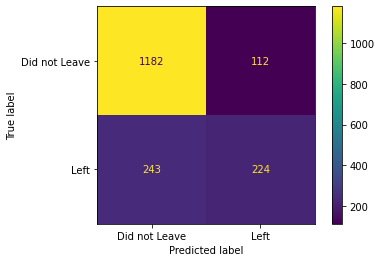

In [110]:
plot_confusion_matrix(clf, X_test, y_test, values_format='d', display_labels=['Did not Leave', 'Left'])

> In the confusion matrix, we see that of the `1294` people that `did not leave`, 1182 were correctly calssified. And of the `467` people that `left the company`, `224` were correctly classified. So that `XGBoost` model was not awesome. Part of the problem is that our data is imbalanced, which we saw earlier and we see this in the confusion matrix with the top row showing `1294` people that did not default and the bottom row showing`467` people who did. Because people leaving costs the company a lot of money, we would like to capture more of the people that left. The good news is that `XGBoost` has a parameter, `scale_pos_weight`, that helps with imbalanced data. So let's try to improve predictions using `Cross Validation` to optimize the paremeters.

## Optimize Parameters using Cross Validation and GridSearchCV()
> `XGBoost` has a lot of `hyperparameters`, parameters that we have to manual configure and are not determined by `XGBoost` itself, including `max_depth`, the maximum tree depth, `learning_rate`, the learning rate, or `eta`, `gamma`, the parameter that encourages pruning, and `reg_lambda`, the regularization parameter lambda. So let's try to find the optimal values for these hyperparameters in hopes that we can improve the accuracy with the `Testing Dataset`.

### Note
> Since we have many hyperperameters to optimize, we will use `GridSearchCV()`. We specify a bunch of potential values for the hyperparameters and `GridSearchCV()` tests all possible combinations of the parameters for us.

In [111]:
param_grid = { 
    'max_depth': [3, 4, 5], 
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0,25, 1],
    'reg_lambda': [0, 1, 10,],
    'scale_pos_weight': [1, 3, 5]
}

In [113]:
optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', seed=42, subsample=0.9, colsample_bytree=0.5),
                              param_grid = param_grid, scoring = 'roc_auc', verbose = 0, n_jobs = 10, cv = 3)

In [114]:
optimal_params

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.5, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=42, silent=None,
                                     subsample=0.9, verbosity=1),
             iid='deprecated', n_jobs=10,
             param_grid={'gamma': [0, 0, 25, 1],
                         'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [3, 4, 5], 'reg_lambda': [0, 

> ### Output:
`max_depth` = 3, `learning_rate` = 0.1, `gamma` = 0, `reg_lambda` = 1, `scale_pos_weight` = 1

In [115]:
optimal_params.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)], verbose=False)
print(optimal_params.best_params_)

{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 10, 'scale_pos_weight': 1}


> So, after testing all possible combinatins of the potential parameter values with `Cross Validation`, we see that we should set `max_depth` = 3, `learning_rate` = 0.1, `gamma` = 1, `reg_lambda` = 10, `scale_pos_weight` = 1

## Building, Evaluating, Drawing and Interpreting the Optimized XGBoost Model
> Now that we have the ideal parameter values, we can build the final `XGBoost` model:

In [118]:
clf = xgb.XGBClassifier(seed=42, objective='binary:logistic', gamma=.25, learing_rate=0.1, max_depth=4, 
                        reg_lambda=10, scale_pos_weight=3, subsample=0.9, colsample_bytree=0.5)

clf.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.547017
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.589081
[2]	validation_0-aucpr:0.60796
[3]	validation_0-aucpr:0.611333
[4]	validation_0-aucpr:0.625231
[5]	validation_0-aucpr:0.625897
[6]	validation_0-aucpr:0.6262
[7]	validation_0-aucpr:0.62666
[8]	validation_0-aucpr:0.626944
[9]	validation_0-aucpr:0.628164
[10]	validation_0-aucpr:0.63643
[11]	validation_0-aucpr:0.636894
[12]	validation_0-aucpr:0.637359
[13]	validation_0-aucpr:0.639441
[14]	validation_0-aucpr:0.640242
[15]	validation_0-aucpr:0.646282
[16]	validation_0-aucpr:0.646874
[17]	validation_0-aucpr:0.645595
[18]	validation_0-aucpr:0.646093
[19]	validation_0-aucpr:0.64731
[20]	validation_0-aucpr:0.646073
[21]	validation_0-aucpr:0.648637
[22]	validation_0-aucpr:0.648432
[23]	validation_0-aucpr:0.648595
[24]	validation_0-aucpr:0.647967
[25]	validation_0-aucpr:0.648012
[26]	validation_0-aucpr:0.643332
[27]	validation_0-aucpr:0.647678
[28]	validation_0-aucpr:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25,
              learing_rate=0.1, learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=10, scale_pos_weight=3,
              seed=42, silent=None, subsample=0.9, verbosity=1)

> Now let's draw another confusion matrix to see if the optimized `XGBoost` model does better.

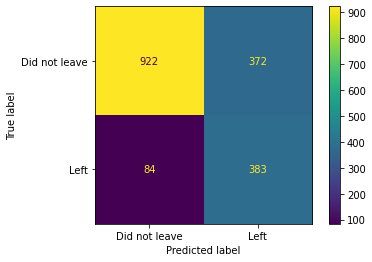

In [119]:
plot_confusion_matrix(clf, X_test, y_test, display_labels=['Did not leave', 'Left'], values_format='d')

> We see that the optimized `XGBoost` model is a lot better at identifying people that left the company. Of the `467` people that left the company, `383`, were correctly identified. Before optimization, we only correctly identified `224`. However, this improvement was at the expense of not being able to correctly classify as many people that did not leave. Before, optimization, we correctly identified `1182` people that did not leave. Now we only correctly classify `922`. That said, this trade off may be better for the company because now it can focus resources on the people that leave if that will help them retain them.

> The last thing we are going to do is draw the first `XGBoost` tree and discuss how to interpret it.

weight:  {'Contract_Two_year': 1, 'tenure': 1, 'DeviceProtection_No_internet_service': 1, 'MonthlyCharges': 4, 'TotalCharges': 3, 'PaymentMethod_Electronic_check': 1}
gain:  {'Contract_Two_year': 1050.4021, 'tenure': 392.192688, 'DeviceProtection_No_internet_service': 226.627075, 'MonthlyCharges': 104.141780825, 'TotalCharges': 25.241268483333332, 'PaymentMethod_Electronic_check': 81.2462158}
cover:  {'Contract_Two_year': 1820.25, 'tenure': 1516.75, 'DeviceProtection_No_internet_service': 644.0, 'MonthlyCharges': 511.5, 'TotalCharges': 62.083333333333336, 'PaymentMethod_Electronic_check': 556.25}
total_gain:  {'Contract_Two_year': 1050.4021, 'tenure': 392.192688, 'DeviceProtection_No_internet_service': 226.627075, 'MonthlyCharges': 416.5671233, 'TotalCharges': 75.72380545, 'PaymentMethod_Electronic_check': 81.2462158}
total_cover:  {'Contract_Two_year': 1820.25, 'tenure': 1516.75, 'DeviceProtection_No_internet_service': 644.0, 'MonthlyCharges': 2046.0, 'TotalCharges': 186.25, 'PaymentM

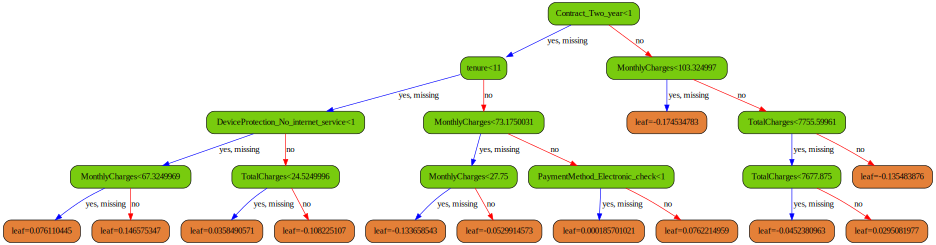

In [128]:
clf = xgb.XGBClassifier(seed=42, objective='binary:logistic', gamma=.25, learing_rate=0.1, max_depth=4, 
                        reg_lambda=10, scale_pos_weight=3, subsample=0.9, colsample_bytree=0.5, n_estimators=1)

clf.fit(X_train, y_train)

bst = clf.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box', 'style': 'filled, rounded', 'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box', 'style': 'filled, rounded', 'fillcolor': '#e48038'}

xgb.to_graphviz(clf, num_trees=0, size="13,20", condition_node_params=node_params, leaf_node_params=leaf_params)

> Now let's discuss how to interpred the `XGBoost` tree. In each node we have:
- The variable (column name) and the threshold for splitting the observations.
- Each branch either says `yes` or `no` and some also say `missing`.
- `leaf` tells us the output value for each leaf.